# Notes to self:
* Need to explain that underline = group

# HDF Utils Tutorial

The h5py python package provides great functions to create and manage data in HDF5 files. In pycroscopy.hdf_utils, we have added functions that facilitate scientifically relevant, or pycroscopy specific functionality such as easy creation of Pycroscopy Main datasets, creation of automatically indexed groups to hold results of an analysis, etc. The following guide provides examples of how, and more importantly when, to use functions in pycroscopy.hdf_utils for various scenarios starting from recording data from instruments to storing analysis data.

## Functions organized by purpose:

* Other:
    * print_tree <-- done
* Searching / Lookup:
    * find_dataset
    * find_results_groups
    * get_all_main
    * get_auxillary_datasets
    * get_group_refs
    * get_h5_obj_refs
    * get_source_dataset
    * check_for_matching_attrs
    * check_for_old
* Main related:
    * check_if_main <-- done
    * get_data_descriptor <-- done
    * reshape_to_n_dims
    * reshape_to_2d
* Ancillary datasets related:
    * get_formatted_labels
    * get_dimensionality
    * get_sort_order
    * get_unit_values
* Attributes - Read <------- DONE
    * get_attr <-- done
    * get_attributes <-- done
    

* Attributes - Write
    * write_simple_attrs <-- done
    * write_book_keeping_attrs
    * copy_attributes
    * copy_main_attributes
* Creating main datasets
    * write_main_dataset <--- DONE
    * create_empty_dataset
* Automated writing of ancillary matrices
    * write_ind_val_dsets
    * write_reduced_spec_dsets
* Low-end functions
    * is_editable_h5
* Group creation:
    * assign_group_index
    * create_indexed_group
    * create_results_group
* Linking
    * link_as_main
    * link_h5_objects_as_attrs <-- DONE
    * link_h5_obj_as_alias <-- DONE
    * check_and_link_ancillary
    
    
* Region references (ADVANCED section)
    * create_region_reference
    * copy_region_refs
    * copy_reg_ref_reduced_dim
    * simple_region_ref_copy
    * attempt_reg_ref_build
    * clean_reg_ref
    * get_region <-- Should be incorporated into existing tutorial
    * write_region_references
    * get_indices_for_region_ref

## Storyboard:
This storyboard must be reflective of actual problems / tasks faced by users - starting from translation to analysis

* create indexed group
    * write simple attributes
* create main dataset as empty dataset
    * Fill in with random values
    * write simple attributes
* create new unindexed group manually
    * write basic attributes to this group
    * Link it to main - link_h5_objects_as_attrs
* create some other dataset
    * Link it to this misc group - link_h5_obj_as_alias
* Ceate
* create results
    * create results group
    * create main dataset with data but reuse only one set of ancillary datasets from source
        * write simple attributes
* create a new results group but this time use assign group name and show that results are the same
    * copy dataset from main - empty
    * fill in the data
    * copy attributes from other results
* Show that is_editable is True
* close the file
    * is_editable should be False here
* Reopen in read-only
    * is_editable should be False again

In [1]:
import sys
import numpy as np
sys.path.append('../../pycroscopy/')
import h5py
import matplotlib.pyplot as plt 
%matplotlib inline

import pycroscopy as px

//anaconda/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
../../pycroscopy/pycroscopy/__init__.py:25: UserWarning: You are using the unity_dev branch, which is aimed at a 1.0 release for pycroscopy. Be advised - this branch changes very significantly and frequently. It is therefore not meant for usage. Use the master or dev branches for regular purposes.
  warn('You are using the unity_dev branch, which is aimed at a 1.0 release for pycroscopy. '


## Create an HDF5 file using h5py

In [2]:
h5_file = h5py.File('test.h5')

## Create an ordinary group

We can always use the h5py functionality to create a HDF5 group:

In [3]:
h5_some_group = h5_file.create_group('Some_Group')

## Create a dataset
Similarly, we can create ordinary HDF5 datasets using h5py functionality:

In [4]:
h5_some_dataset = h5_some_group.create_dataset('Some_Dataset', np.arange(5))

## Create an indexed group
Let us first create a HDF5 group to store some data recorded from an instrument. The below function will automatically create a group with an index as a suffix and write certain book-keeping attributes to the group. We will see how this and similar functions handle situations when similarly named groups already exist.

In [5]:
h5_meas_group = px.hdf_utils.create_indexed_group(h5_file, 'Measurement')

## Look at datasets and data groups in the created file
The print_tree() function is great for looking at the datasets and datagroups contained in a file. 

In [6]:
print('Contents within the file so far:')
px.hdf_utils.print_tree(h5_file)

Contents within the file so far:
/
├ Measurement_000
  ---------------
├ Some_Group
  ----------
  ├ Some_Dataset


Clearly, all we have right now is a single group - Measurement_000 (hence the the underline). 

## Getting all attributes

Here's a look at the self-explanatory, default attribtues that will be written to the group for traceability and posterity.

In [7]:
print('Attributes contained within {}'.format(h5_meas_group))
for key, val in px.hdf_utils.get_attributes(h5_meas_group).items():
    print('%s : %s' % (key, val))

Attributes contained within <HDF5 group "/Measurement_000" (0 members)>
timestamp : 2018_04_20-08_53_11
pycroscopy_version : 0.59.7
machine_id : mac109728.ornl.gov


We could use the write_simple_attrs() function to add / modify additional attributes to the group:

In [8]:
px.hdf_utils.write_simple_attrs(h5_meas_group, {'Instrument': 'Atomic Force Microscope',
                                                'User': 'Joe Smith',
                                                'Room Temperature [C]': 23})

Individual attributes can be extracted using the similar get_attr() function as shown below:

In [9]:
print(px.hdf_utils.get_attr(h5_meas_group, 'User'))

Joe Smith


## Set up a toy dataset

Next, let's set up a toy four-dimensional dataset that has:
* two position dimensions:
    * X
    * Y
* and two spectroscopic dimensions:
    * (sinusoidal) probing bias waveform
    * cycles over which this bias waveform is repeated
    
For simplicity, we will keep the size of each dimension small. 

In [10]:
num_rows = 3
num_cols = 5
num_cycles = 2
bias_pts = 7

source_main_data = np.random.rand(num_rows * num_cols, bias_pts * num_cycles)

## Specify position and spectroscopic dimensions

Next, let us determine how each of the position and spectroscopic dimensions are varied

In [11]:
rows_vals = np.arange(-0.1, 0.15, 0.1)
cols_vals = np.arange(400, 900, 100)
bias_vals = 2.5 * np.sin(np.linspace(0, 2*np.pi, bias_pts, endpoint=False))
cycle_vals = np.arange(num_cycles)

For better understanding of this dataset, let us take a look at the different values these dimensions can take

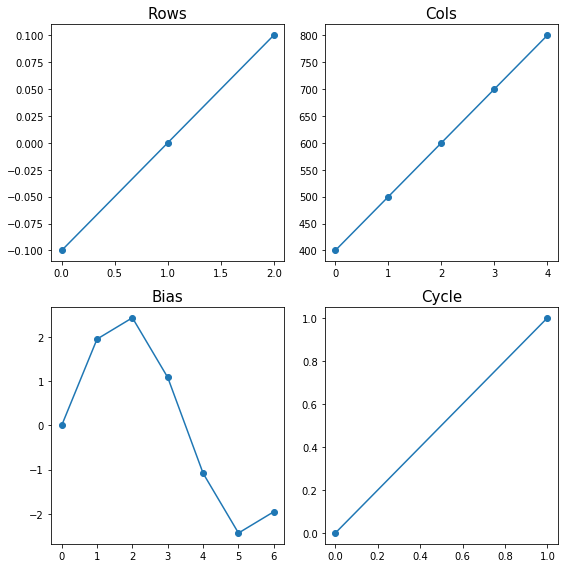

In [12]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 8))
for axis, vals, dim_name in zip(axes.flat, [rows_vals, cols_vals, bias_vals, cycle_vals], 
                                ['Rows', 'Cols', 'Bias', 'Cycle']):
    axis.set_title(dim_name, fontsize=15)
    axis.plot(vals, 'o-')
fig.tight_layout()

In pycroscopy, position and spectrosocpic dimensions are defined using some basic information that will be incorporated in Dimension objects that contain three vial pieces of information:
* Name of the dimension
* units for the dimension
* values:
    * These can be the actual values over which the dimension was varied
    * or number of steps in case of linearly varying dimensions such as 'Cycle' below 

In [13]:
pos_dims = [px.write_utils.Dimension('Rows', 'um', rows_vals), 
            px.write_utils.Dimension('Cols', 'nm', cols_vals)]
spec_dims = [px.write_utils.Dimension('Bias', 'V', bias_vals), 
            px.write_utils.Dimension('Cycle', '', num_cycles)]

## Create and write a Main dataset to HDF5:

Often, data is is recorded (from instruments) or generated (as a result of some analysis) in chunks (for example - one position at a time). Therefore, it makes sense to first create an empty dataset and then fill in the data as it is generated / recorded. 

Even though we already have the data prepared in *source_main*, we will only create an empty dataset first by specifying how large the dataset should be. Later, we will go over examples where the whole data is available when creating the HDF5 dataset. The *write_main_dataset* is one of the most important and popularly used functions in hdf_utils since it handles:
* thorough validation of all inputs
* the creation of the central dataset
* the creation of the ancillary datasets (if necessary)
* linking the ancillary datasets such that the central dataset becomes a *Main* dataset
* writing attributes

We could use the write_simple_attrs() function to write attributes to Raw_Data at a later stage but we can always pass these attributes to be written at the time of dataset creation if they are already known

In [14]:
h5_raw = px.hdf_utils.write_main_dataset(h5_meas_group, source_main_data.shape, 'Raw_Data', 'Current', 'nA', 
                                         pos_dims, spec_dims, 
                                         main_dset_attrs={'IO_rate': 4E+6, 'Amplifier_Gain': 9})
print(h5_raw)

<HDF5 dataset "Raw_Data": shape (15, 14), type "<f4">
located at: 
/Measurement_000/Raw_Data 
Data contains: 
Current (nA) 
Data dimensions and original shape: 
Position Dimensions: 
Rows - size: 3 
Cols - size: 5 
Spectroscopic Dimensions: 
Bias - size: 7 
Cycle - size: 2


Let us take a look at the contents of the file again using the print_tree() functon. What we see is that five new datasets have been created: 
* **Raw_Data** was created to contain the 4D measurement we are interested in storing. 
* **Spectrocopic_Indices** and **Spectrocopic_Values** contain the information about the spectroscopic dimensions
* **Position_Indices** and **Position_Values** contain the position related information

The underline below **Measurement_000** indicates that this is a HDF5 Group

In [15]:
px.hdf_utils.print_tree(h5_file)

/
├ Measurement_000
  ---------------
  ├ Position_Indices
  ├ Position_Values
  ├ Raw_Data
  ├ Spectroscopic_Indices
  ├ Spectroscopic_Values
├ Some_Group
  ----------
  ├ Some_Dataset


As mentioned in our document about the data_format, the four supporting datasets (Position and Spectroscopic Indices and Values) help provide meaning to each element in Raw_Data such as dimensionality, etc. 

Only the Raw_Data dataset is a Pycroscopy Main dataset while all other datasets are just supporting datasets. We can verify whether a dataset is a Main dataset or not using the check_if_main() function: 

In [16]:
for dset in [h5_raw, h5_raw.h5_spec_inds, h5_raw.h5_pos_vals]:
    print('Is {} is a Main dataset?: {}'.format(dset.name, px.hdf_utils.check_if_main(dset)))

Is /Measurement_000/Raw_Data is a Main dataset?: True
Is /Measurement_000/Spectroscopic_Indices is a Main dataset?: False
Is /Measurement_000/Position_Values is a Main dataset?: False


One handy function that is useful to understand the contents of Main datasets is get_data_descriptor(). It essentially concatenates the quantity and units attributes of a Main dataset:

In [17]:
px.hdf_utils.get_data_descriptor(h5_raw)

'Current (nA)'

## Populating the Dataset:

Note that h5_main still does not contain the values we are interested in filling it in with:

In [18]:
h5_raw[5]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

Let us simulate a situation where we are recording the data a pixel at a time and writing it to the h5_main dataset:

In [19]:
for pixel_ind, pixel_data in enumerate(source_main_data):
    h5_raw[pixel_ind] = pixel_data

# Make sure to flush the file (write anything in the buffer into the file)
h5_file.flush()

Note that we were only simulating a (realistic) situation where all the data was not present at once to write into Raw_Data dataset. Let us check the contents at a particular position in the dataset now:

In [20]:
h5_raw[5]

array([0.76854867, 0.25454953, 0.4329743 , 0.9786843 , 0.88994837,
       0.119339  , 0.34586716, 0.65612423, 0.98471534, 0.42844138,
       0.23466794, 0.6439775 , 0.85732377, 0.40549588], dtype=float32)

## Exploring attributes in Main datasets:

Some of the main requirements for promoting a regular dataset to a Main dataset are some mandatory attributes attached to the dataset:
* quantity - What the stored data contains - for example: current, temperature, voltage, strain etc.
* units - the units for the quantity, such as Amperes, meters, etc.
* links to each of the four ancillary datasets 

Again, we can use the get_attributes() function to see if and how these attributes are stored:

In [21]:
px.hdf_utils.get_attributes(h5_raw)

{'Amplifier_Gain': 9,
 'IO_rate': 4000000.0,
 'Position_Indices': <HDF5 object reference>,
 'Position_Values': <HDF5 object reference>,
 'Spectroscopic_Indices': <HDF5 object reference>,
 'Spectroscopic_Values': <HDF5 object reference>,
 'machine_id': 'mac109728.ornl.gov',
 'pycroscopy_version': '0.59.7',
 'quantity': 'Current',
 'timestamp': '2018_04_20-08_53_16',
 'units': 'nA'}

While it is straightforward to read simple attributes like quantity or units, the values for Position_Values or Spectroscopic_Indices attributes seem cryptic. These are just references or links to other datasets. 

In [22]:
px.hdf_utils.get_attr(h5_raw, 'Position_Indices')

<HDF5 object reference>

## Reading Links

We can get access to linked datasets using get_auxillary_datasets():

In [23]:
px.hdf_utils.get_auxillary_datasets(h5_raw, 'Position_Indices')

[<HDF5 dataset "Position_Indices": shape (15, 2), type "<u4">]

Note that this function returns all datasets named 'Position_Indices' under a group or Dataset in a list. In this case, we know that the list should only have one value. Given that h5_raw is a Main dataset, and Position_Indices is one of the four essential components of a Main dataset, the Pycrodataset object makes it far easier to access the ancillary datasets without neededing to call a function as above. PycroDataset will be discussed in greater detail in a separate notebook.

## Creating links 

What do we do if we need to store some other supporting information regarding some measurement? If such supporting datasets do not need to be Pycroscopy Main datasets, we could simply use the basic functionality of h5py to create the dataset

In [24]:
h5_other = h5_meas_group.create_dataset('Other', np.random.rand(5))

Pycroscopy files tend to have a fair number of datasets in them and the most important ones are Main datasets and users tend to "walk" or "hop" through the file by stepping only on the Main datasets. Thus, we often want to link supporting datasets to the relevant Main datasets. This way, such supporting datasets can be accessed via an attribute of the Main dataset instead of having to manually specify the path of the supporting dataset. 

link_h5_objects_as_attrs() makes it easy to link a dataset or group to any other dataset or group. In this example we will link the 'Other' dataset to the Main dataset:

In [25]:
px.hdf_utils.link_h5_objects_as_attrs(h5_raw, h5_other)
px.hdf_utils.get_attributes(h5_raw)

{'Amplifier_Gain': 9,
 'IO_rate': 4000000.0,
 'Other': <HDF5 object reference>,
 'Position_Indices': <HDF5 object reference>,
 'Position_Values': <HDF5 object reference>,
 'Spectroscopic_Indices': <HDF5 object reference>,
 'Spectroscopic_Values': <HDF5 object reference>,
 'machine_id': 'mac109728.ornl.gov',
 'pycroscopy_version': '0.59.7',
 'quantity': 'Current',
 'timestamp': '2018_04_20-08_53_16',
 'units': 'nA'}

In the same way, we can even link a group to the Other dataset:

In [26]:
h5_some_group = h5_meas_group.create_group('Some_Group')
px.hdf_utils.link_h5_objects_as_attrs(h5_other, h5_some_group)
px.hdf_utils.get_attributes(h5_other)

{'Some_Group': <HDF5 object reference>}

What we see above is that 'Other' is now an attribute of the 'Raw_Data' dataset. 

One common scenario in scientific workflows is the storage of multiple Main Datasets within the same group. The first Main dataset can be stored along with its four ancillary datasets without any problems. However, if the second Main dataset also requires the storage of Position and Spectroscopic datasets, these datasets would need to be named differently to avoid conflicts with existing datasets (associated with the first Main dataset). Moreover, these ancillary datasets would need to be linked to the second Main dataset with the standard 'Position_..' and 'Spectroscopic_..' names for the attributes. 

The link_h5_obj_as_alias() is handy in this scenario since it allows a dataset or group to be linked with a name different from its actual name. For example, we can link the 'Raw_Data' dataset to the 'Other' dataset with an alias:

In [27]:
px.hdf_utils.link_h5_obj_as_alias(h5_other, h5_raw, 'Mysterious_Dataset')

px.hdf_utils.get_attributes(h5_other)

{'Mysterious_Dataset': <HDF5 object reference>,
 'Some_Group': <HDF5 object reference>}

The datased named 'Other' has a new attribute named 'Mysterious_Dataset'. Let us show that this dataset is none other than Raw_Data: 

In [28]:
h5_myst_dset = px.hdf_utils.get_auxillary_datasets(h5_other, 'Mysterious_Dataset')[0]

print(h5_myst_dset == h5_raw)

True


# Performing some Processing
Let us assume that we are normalizing the data in some way and we need to write the results back to the file. As far as the data shapes and dimensionality are concerned, let us assume that the data still remains a 4D dataset. Therefore, the new results datset can reuse the ancillary datasets from h5_raw. In this scenario we will demonstrate how one might write a Main dataset when having the complete processed (in this case some normalization) data is available before even creating the dataset.

## Create results Group
Let us first start off with creation of a HDF5 Group that will contain the results. If you recall, groups that contain the results of some processing / analysis on a source dataset are named as 'Source_Dataset_name-Process_Name_00x' where x is the index of the group. The create_results_group() function makes it very easy to create a group with such nomenclature and indexing:

In [ ]:
h5_results_group_1 = p

In [ ]:
Just to show that the dataset was indeed created as a 
print('h5_main is of type: {}'.format(type(h5_main)))

* create new unindexed group manually
    * write basic attributes to this group
* create results
    * create results group
    * create main dataset with data but reuse only one set of ancillary datasets from source
        * write simple attributes
* create a new results group but this time use assign group name and show that results are the same
    * copy dataset from main - empty
    * fill in the data
    * copy attributes from other results
* Show that is_editable is True
* close the file
    * is_editable should be False here
* Reopen in read-only
    * is_editable should be False again

In [ ]:
new_group_name = px.hdf_utils.assign_group_index(h5_file, 'Raw_Data-Normalization')
print(new_group_name)

In [ ]:
h5_new_group = h5_file.create_group(new_group_name)

In [ ]:
norm_data = np.random.rand(num_rows * num_cols, bias_pts * num_cycles)

### Reusing existing ancillary datasets + writing empty data

In [ ]:
h5_norm = px.hdf_utils.write_main_dataset(h5_new_group, source_main_data.shape, 'Raw_Data', 'Current', 'nA', 
                                          None, spec_dims, 
                                          h5_pos_inds=h5_main.h5_pos_inds, h5_pos_vals=h5_main.h5_pos_vals)

print(h5_norm)

In [ ]:
# Let's figure out the parent group under which h5_norm sits:
h5_norm_parent = h5_norm.parent
print(h5_norm_parent)

In [ ]:
# What if we needed to add more (auxillary) datases for normalization:
h5_other_dset = h5_norm_parent.create_dataset('Other', np.random.rand(15))

In [ ]:
# Let's look at the attributes of h5_norm to see what attributes have been written:
px.hdf_utils.get_attributes(h5_norm)

In [ ]:
# What if we want to link this to the main dataset for some reason?
px.hdf_utils.link_h5_objects_as_attrs(h5_norm, h5_other_dset)

In [ ]:
# Let's look at the attributes of h5_norm to see if the new dataset has been linked as an attribute:
px.hdf_utils.get_attributes(h5_norm)

In [ ]:
# What if we needed to add yet another (auxillary) dataset for normalization:
h5_some_other = h5_norm_parent.create_dataset('Some_Other', np.random.rand(5))

In [ ]:
px.hdf_utils.link_h5_obj_as_alias(h5_norm, h5_some_other, 'Blah_Blah')

# Let's look at the attributes of h5_norm to see if the new dataset has been linked as an attribute:
px.hdf_utils.get_attributes(h5_norm)

In [ ]:
# Just to prove that this is indeed hte same dataset, let's get the linked dataset:
matches = px.hdf_utils.get_auxillary_datasets(h5_norm, 'Blah_Blah')
print(matches)

In [ ]:
print(matches[0] == h5_some_other)

### Oh no! we forgot to write attributes

In [ ]:
new_group_name = px.hdf_utils.assign_group_index(h5_file, 'Raw_Data-Normalization')
print(new_group_name)

In [ ]:
px.hdf_utils.is_editable_h5(h5_file)

In [ ]:
# close the file and try:
px.hdf_utils.is_editable_h5(h5_file)

In [ ]:
# Open the file again in r mode:
px.hdf_utils.is_editable_h5(h5_file)

In [ ]:
spec_desc = Dimension('Bias', 'V', np.arange(self.num_x_steps))
        ds_spec_inds, ds_spec_vals = build_ind_val_dsets(spec_desc, is_spectral=True, verbose=self.verbose)

        cap_shape = (num_pos, 1)
        ds_cap = VirtualDataset('Capacitance', data=None, maxshape=cap_shape, dtype=cap_dtype, chunking=cap_shape,
                                compression='gzip')
        ds_cap.attrs = {'quantity': 'Capacitance', 'units': 'pF'}
        cap_spec_desc = Dimension('Direction', '', [1])
        ds_cap_spec_inds, ds_cap_spec_vals = build_ind_val_dsets(cap_spec_desc, is_spectral=True, verbose=self.verbose)
        # the names of these datasets will clash with the ones created above. Change names manually:
        ds_cap_spec_inds.name = 'Spectroscopic_Indices_Cap'
        ds_cap_spec_vals.name = 'Spectroscopic_Values_Cap'

        ds_r_var = VirtualDataset('R_variance', data=None, maxshape=(num_pos, self.num_x_steps), dtype=np.float32,
                                  chunking=(1, self.num_x_steps), compression='gzip')
        ds_r_var.attrs = {'quantity': 'Resistance', 'units': 'GOhms'}
        ds_res = VirtualDataset('Resistance', data=None, maxshape=(num_pos, self.num_x_steps), dtype=np.float32,
                                chunking=(1, self.num_x_steps), compression='gzip')
        ds_res.attrs = {'quantity': 'Resistance', 'units': 'GOhms'}
        ds_i_corr = VirtualDataset('Corrected_Current', data=None, maxshape=(num_pos, self.single_ao.size),
                                   dtype=np.float32,
                                   chunking=(1, self.single_ao.size), compression='gzip')
        # don't bother adding any other attributes, all this will be taken from h5_main

        bayes_grp = VirtualGroup(self.h5_main.name.split('/')[-1] + '-' + self.process_name + '_',
                                 parent=self.h5_main.parent.name)
        bayes_grp.add_children([ds_spec_inds, ds_spec_vals, ds_cap, ds_r_var, ds_res, ds_i_corr,
                                ds_cap_spec_inds, ds_cap_spec_vals])
        bayes_grp.attrs = {'algorithm_author': 'Kody J. Law', 'last_pixel': 0}
        bayes_grp.attrs.update(self.parms_dict)

        if self.verbose:
            bayes_grp.show_tree()

        self.hdf = HDFwriter(self.h5_main.file)
        h5_refs = self.hdf.write(bayes_grp, print_log=self.verbose)

        self.h5_new_spec_vals = get_h5_obj_refs(['Spectroscopic_Values'], h5_refs)[0]
        h5_new_spec_inds = get_h5_obj_refs(['Spectroscopic_Indices'], h5_refs)[0]
        h5_cap_spec_vals = get_h5_obj_refs(['Spectroscopic_Values_Cap'], h5_refs)[0]
        h5_cap_spec_inds = get_h5_obj_refs(['Spectroscopic_Indices_Cap'], h5_refs)[0]
        self.h5_cap = get_h5_obj_refs(['Capacitance'], h5_refs)[0]
        self.h5_variance = get_h5_obj_refs(['R_variance'], h5_refs)[0]
        self.h5_resistance = get_h5_obj_refs(['Resistance'], h5_refs)[0]
        self.h5_i_corrected = get_h5_obj_refs(['Corrected_Current'], h5_refs)[0]
        self.h5_results_grp = self.h5_cap.parent

        if self.verbose:
            print('Finished making room for the datasets. Now linking them')

        # Now link the datasets appropriately so that they become hubs:
        h5_pos_vals = get_auxillary_datasets(self.h5_main, aux_dset_name=['Position_Values'])[0]
        h5_pos_inds = get_auxillary_datasets(self.h5_main, aux_dset_name=['Position_Indices'])[0]

        # Capacitance main dataset:
        link_as_main(self.h5_cap, h5_pos_inds, h5_pos_vals, h5_cap_spec_inds, h5_cap_spec_vals)

        # the corrected current dataset is the same as the main dataset in every way
        copy_attributes(self.h5_main, self.h5_i_corrected, skip_refs=False)

        # The resistance datasets get new spec datasets but reuse the old pos datasets:
        for new_dset in [self.h5_resistance, self.h5_variance]:
            link_as_main(new_dset, h5_pos_inds, h5_pos_vals, h5_new_spec_inds, self.h5_new_spec_vals)

        if self.verbose:
            print('Finished linking all datasets!')

        self.hdf.flush()